In [408]:
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_palette('muted')
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, \
ExtraTreesRegressor, GradientBoostingRegressor,\
AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, \
RandomForestClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

## Webscraping

### IMDB: Get film ids

In [3]:
# Function that will make an api call to omdbapi.com and return film id

def get_id_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

entries = get_id_250()

In [4]:
print len(entries)
print entries[:2]

250
[u'tt2582802', u'tt0047478']


### Fill in film data from omdapi.com

In [5]:
# Function that will make an api call to omdbapi.com and return film data by film id

#Decided to include Rotten Tomatoes ratings and metrics as it may also be a useful feature in models 

# From JSON/APIs lab
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry+'&plot=full&r=json&tomatoes=true')
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

entries_dict_list = [get_entry(e) for e in entries]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [6]:
len(entries_dict_list)

250

In [7]:
df = pd.DataFrame(entries_dict_list)
df.head(1)

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoFresh,tomatoImage,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,246,certified,94,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66092


In [ ]:
print df.shape

### IMDB: Get gross, opening weekend and budget

In [8]:
def get_gross(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        gross_list = re.findall("Gross:</h4>[ ]*\$([^ ]*)", html)
        gross = int(gross_list[0].replace(',', ''))
        print '.',
        return gross
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [9]:
grosses = [(e, get_gross(e)) for e in entries]

. . . . . . .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200
. . . .
list index out of range tt0074896 200
. .
list index out of range tt0021749 200
. .
list index out of range tt0053125 200
. . .
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0083922 200
. . .
list index out of range tt0072684 200
.
list index out of range tt0074958 200
. . . .
list index out of range tt0036775 200
. . . . . .
list index out of range tt0978762 200

list index out of range tt0109117 200
. .
list index out of range tt0080678 200
. .
list index out of range tt0056592 200
.
list index out of range tt0095327 200
. . .
list index out of range tt0476735 200

list index out of range tt1821480 200
. . . . . .
list index out of range tt0046438 200
.
list index out of range tt0015864 200
.
list index out of range tt0045152 200
. . . .
li

In [10]:
df1 = pd.DataFrame(grosses, columns=['imdbID', 'Gross'])
df1.head(3)

,imdbID,Gross
0,tt2582802,13092000.0
1,tt0047478,269061.0
2,tt0082971,242374454.0


In [11]:
def get_opening(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        opening_list = re.findall("Opening Weekend:</h4>[ ]*\$([^ ]*)", html)
        opening = int(opening_list[0].replace(',', ''))
        print '.',
        return opening
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [12]:
opening = [(e, get_opening(e)) for e in entries]

. . .
list index out of range tt0050212 200

list index out of range tt0986264 200
. .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200

list index out of range tt0114746 200
. . .
list index out of range tt0074896 200
. .
list index out of range tt0021749 200
.
list index out of range tt1187043 200

list index out of range tt0053125 200
.
list index out of range tt0112471 200
.
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0083922 200

list index out of range tt0088247 200
.
list index out of range tt0087843 200

list index out of range tt0072684 200
.
list index out of range tt0074958 200
.
list index out of range tt0052618 200
. .
list index out of range tt0036775 200
.
list index out of range tt0110357 200
. . .
list index out of range tt0075148 200

list index out of range tt0978762 200

list index out of r

In [13]:
df2 = pd.DataFrame(opening, columns=['imdbID', 'Opening'])
df2.head(3)

,imdbID,Opening
0,tt2582802,135388.0
1,tt0047478,21830.0
2,tt0082971,1673731.0


In [14]:
def get_budget(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        budget_list = re.findall("Budget:</h4>[ ]*\$([^ ]*)", html)
        budget = int(budget_list[0].replace(',', ''))
        print '.',
        return budget
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [15]:
budgets = [(e, get_budget(e)) for e in entries]

. . . .
list index out of range tt0986264 200
. .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . . . . . .
list index out of range tt0363163 200
.
list index out of range tt1865505 200
. . . . .
list index out of range tt1187043 200
. . . . . . . . . . . . . . . . . . . . . . .
list index out of range tt0071853 200
. .
list index out of range tt0978762 200

list index out of range tt0109117 200
. . . . . . . . . . .
list index out of range tt0476735 200

list index out of range tt1821480 200
.
list index out of range tt0044741 200
. . . .
list index out of range tt0046438 200
. . . . . . . .
list index out of range tt0046911 200
.
list index out of range tt0050986 200
.
list index out of range tt0091251 200
. . . . .
list index out of range tt0113247 200
. . . . . . . . . . .
list index out of range tt0060827 200
. .
list index out of range tt0211915 200
. . . . . . .
list index out of range tt0053198 200
. . . . . . . . . .
list index out of range

In [16]:
df3 = pd.DataFrame(budgets, columns=['imdbID', 'Budget'])
df3.head()

,imdbID,Budget
0,tt2582802,3300000.0
1,tt0047478,2000000.0
2,tt0082971,18000000.0
3,tt0050212,3000000.0
4,tt0986264,NaN


In [17]:
print df1.columns
print df2.columns
print df3.columns

Index([u'imdbID', u'Gross'], dtype='object')
Index([u'imdbID', u'Opening'], dtype='object')
Index([u'imdbID', u'Budget'], dtype='object')


In [18]:
df_gross = df1.copy()
df_opening = df2.copy()
df_budget = df3.copy()

In [19]:
print df_gross.columns, df_gross.shape
print df_opening.columns, df_opening.shape
print df_budget.columns, df_opening.shape

Index([u'imdbID', u'Gross'], dtype='object') (250, 2)
Index([u'imdbID', u'Opening'], dtype='object') (250, 2)
Index([u'imdbID', u'Budget'], dtype='object') (250, 2)


### Merge all dataframes into 1 master df

In [21]:
# Merge gross, opening and budget dfs
df_imdb = pd.merge(df_gross, df_opening, on="imdbID")
df_imdb = pd.merge(df_imdb, df_budget, on="imdbID")
df_imdb.head(3)

,imdbID,Gross,Opening,Budget
0,tt2582802,13092000.0,135388.0,3300000.0
1,tt0047478,269061.0,21830.0,2000000.0
2,tt0082971,242374454.0,1673731.0,18000000.0


In [22]:
# Merge original df (from omdbapi) with df_imdb
df = pd.merge(df, df_imdb)
print df.shape
df.head(3)

(250, 38)


,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Gross,Opening,Budget
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66092,13092000.0,135388.0,3300000.0
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,N/A,Japan,01 Mar 1999,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",...,9.3,57,0,http://www.rottentomatoes.com/m/1018639-seven_...,97,4.5,89264,269061.0,21830.0,2000000.0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,N/A,USA,21 Oct 2003,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,...,9.2,71,4,http://www.rottentomatoes.com/m/raiders_of_the...,96,4.1,823404,242374454.0,1673731.0,18000000.0


In [20]:
#################
#################

# Copy of merged raw dfs without dropping/rearranging columns or cleaning
#dfc1 = df.copy()

#################
#################

In [ ]:
#df.to_csv('film_df_v6.csv', sep=',', encoding='utf-8')

### Reorder and drop columns

In [23]:
df.columns = [i.encode("utf-8") for i in df.columns]
df.columns.values

array(['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director',
       'Genre', 'Language', 'Metascore', 'Plot', 'Poster', 'Production',
       'Rated', 'Released', 'Response', 'Runtime', 'Title', 'Type',
       'Website', 'Writer', 'Year', 'imdbID', 'imdbRating', 'imdbVotes',
       'tomatoConsensus', 'tomatoFresh', 'tomatoImage', 'tomatoMeter',
       'tomatoRating', 'tomatoReviews', 'tomatoRotten', 'tomatoURL',
       'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 'Gross',
       'Opening', 'Budget'], dtype=object)

In [24]:
original_cols = df.columns.values
cols_list = [
    'imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot', 
    'tomatoConsensus', 'tomatoImage',  'tomatoURL',
    'Website',  'DVD',  'Poster', 'Type', 'Response']

# columns to delete:
# ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
# 'Type', 'Poster', 'Website', 'DVD']

print len(original_cols)
print len(cols_list)

38
38


In [25]:
print df['Type'].value_counts()
print df['Response'].value_counts()

movie    250
Name: Type, dtype: int64
True    250
Name: Response, dtype: int64


In [26]:
# Reindex column order
df = df.reindex(columns=cols_list)
print df.shape
print df.columns.values
df.head(1)

(250, 38)
['imdbID' 'Title' 'BoxOffice' 'Gross' 'Opening' 'Budget' 'Year' 'Released'
 'Metascore' 'imdbRating' 'imdbVotes' 'tomatoMeter' 'tomatoRating'
 'tomatoReviews' 'tomatoUserMeter' 'tomatoUserRating' 'tomatoUserReviews'
 'tomatoFresh' 'tomatoRotten' 'Awards' 'Actors' 'Director' 'Writer'
 'Production' 'Country' 'Language' 'Genre' 'Rated' 'Runtime' 'Plot'
 'tomatoConsensus' 'tomatoImage' 'tomatoURL' 'Website' 'DVD' 'Poster'
 'Type' 'Response']


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Runtime,Plot,tomatoConsensus,tomatoImage,tomatoURL,Website,DVD,Poster,Type,Response
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,107 min,A promising young drummer enrolls at a cut-thr...,"Intense, inspiring, and well-acted, Whiplash i...",certified,http://www.rottentomatoes.com/m/whiplash_2014/,http://sonyclassics.com/whiplash/,24 Feb 2015,https://images-na.ssl-images-amazon.com/images...,movie,True


In [27]:
cols_to_delete = ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
                  'Type', 'Poster', 'Website', 'DVD']

In [28]:
# Create final master df with only 30 columns
df = df[['imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot']]

print df.shape
df.head(2)

(250, 30)


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Actors,Director,Writer,Production,Country,Language,Genre,Rated,Runtime,Plot
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Damien Chazelle,Damien Chazelle,Sony Pictures Classics,USA,English,"Drama, Music",R,107 min,A promising young drummer enrolls at a cut-thr...
1,tt0047478,Seven Samurai,N/A,269061.0,21830.0,2000000.0,1954,19 Nov 1956,98,8.7,...,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Akira Kurosawa,"Akira Kurosawa (screenplay), Shinobu Hashimoto...",Columbia Pictures,Japan,Japanese,"Action, Adventure, Drama",UNRATED,207 min,"A veteran samurai, who has fallen on hard time..."


In [29]:
#######################
#######################

# Copy of merged df with columns cleaned
#dfc2 = df.copy()

#######################
#######################

In [ ]:
#df.to_csv('film_df_v6_2.csv', sep=',', encoding='utf-8')

## Data Cleaning / Munging

### Converting dtypes

In [ ]:
df.info()

### Convert numeric dtypes (floats and int)

In [52]:
# Convert Metascore to float with np.nan for N/A
df['Metascore'] = df['Metascore'].apply(lambda x: np.nan if x == 'N/A' else x)
df['Metascore'] = df['Metascore'].astype(float)

In [53]:
# Convert imdbRating to float
df['imdbRating'] = df['imdbRating'].astype(float)

In [54]:
# Convert imdbVotes to int
df['imdbVotes'] = df['imdbVotes'].apply(lambda x: x.replace(',', ''))
df['imdbVotes'] = df['imdbVotes'].astype(int)

In [ ]:
# Convert all tomato columns to int
tomato_list = ['tomatoMeter', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserReviews',
           'tomatoFresh', 'tomatoRotten', 'tomatoRating', 'tomatoUserRating']

def convert_num(some_list):
    for i in some_list:
        df[i] = df[i].apply(lambda x: np.nan if x == 'N/A' else x)
        df[i] = df[i].astype(float)
    return df[i]

convert_num(tomato_list)

### Convert datetime-related columns (Year, Released and Runtime)

In [56]:
# Convert Year to int
df['Year'] = df['Year'].astype(int)

In [ ]:
df.columns

In [ ]:
df['Released'].value_counts()

In [58]:
# Extract month from release date
df['Month'] = [x[3:6] for x in df['Released']]

In [59]:
# Convert Release to datetime

# Only N/A value is Charlie Chaplin's The Gold Rush
df['Released'] = ['1925-06-25' if i=='N/A' else datetime.strptime(str(i), '%d %b %Y') \
                 for i in df['Released']]
df['Released'].head(3)

0   2014-10-15
1   1956-11-19
2   1981-06-12
Name: Released, dtype: datetime64[ns]

In [60]:
# Create new season bins for release dates

# Only missing value is Charlie Chaplin's The Gold Rush
winter = ['Jan', 'Feb', 'Mar', 'Apr']
summer = ['May', 'Jun', 'Jul']
fall = ['Aug', 'Sep', 'Oct']
holiday = ['Nov', 'Dec']

def bin_months(i):
    if i in winter:
        i = 'Winter'
    elif i in summer:
        i = 'Summer'
    elif i in fall:
        i = 'Fall'
    elif i in holiday:
        i = 'Holiday'
    else:
        i = 'Summer'
    return i

df['Season'] = [bin_months(x) for x in df['Month']]
df['Season'].value_counts()

Winter     83
Fall       59
Summer     58
Holiday    50
Name: Season, dtype: int64

In [61]:
# Convert Runtime to int
def runtime_int(x):
    return int(x.replace(' min', ''))

df['Runtime'] = df['Runtime'].apply(runtime_int)
df['Runtime'].head(2)

0    107
1    207
Name: Runtime, dtype: int64

### Clean up Awards, Rating and Genres

In [62]:
df['Awards'].head()

0     Won 3 Oscars. Another 87 wins & 131 nominations.
1    Nominated for 2 Oscars. Another 5 wins & 6 nom...
2      Won 4 Oscars. Another 30 wins & 23 nominations.
3       Won 7 Oscars. Another 23 wins & 7 nominations.
4                            14 wins & 15 nominations.
Name: Awards, dtype: object

In [63]:
# Make Oscars_Won column with number of Oscars won
def oscar_winners(x):
    try:
        oscar_winner = re.findall(r'([^.]*?Oscar[^.]*\.)',x)[0].split()
        if type(oscar_winner[0]) == int:
            return int(oscar_winner[0])
        elif oscar_winner[0] == 'Won':
            return int(oscar_winner[1])
        else:
            return 0
    except:
        return 0
    
df['Oscars_Won'] = df['Awards'].apply(oscar_winners)
df['Oscars_Won'].head(3)

0    3
1    0
2    4
Name: Oscars_Won, dtype: int64

In [78]:
# Make Oscar_Noms columns
def oscar_noms(x):
    try:
        oscar_noms = re.findall('Nominated\sfor\s(\d)\sOscar',x)[0]
        return int(oscar_noms)
    except:
        return 0

df['Oscar_Noms'] = df['Awards'].apply(oscar_noms)
df['Oscar_Noms'].value_counts()

0    179
1     28
2     12
4      9
3      8
5      6
7      4
6      3
8      1
Name: Oscar_Noms, dtype: int64

In [79]:
# Make Awards_Won column with sum of other awards won
def awards_won(x):
    try:
        awards_won = re.findall('Another\s(\d+)\swins', x)[0]
        return int(awards_won)
    except:
        return 0

df['Awards_Won'] = df['Awards'].apply(awards_won)
df['Awards_Won'].head(3)

0    87
1     5
2    30
Name: Awards_Won, dtype: int64

In [80]:
# Make Other_Noms column with sum of other nominations
def other_noms(x):
    try:
        other_noms = re.findall('(\d+)\snomination', x)[0]
        return int(other_noms)
    except:
        return 0

df['Other_Noms'] = df['Awards'].apply(other_noms)
df['Other_Noms'].head(3)

0    131
1      6
2     23
Name: Other_Noms, dtype: int64

In [81]:
# Clean up Rating column
print df['Rated'].value_counts()
rated_other = ['NOT RATED', 'APPROVED', 'UNRATED', 'PASSED', 'N/A', 'M']

df['Rated'] = df['Rated'].apply(lambda x: x if x not in rated_other else 'OTHER')
df['Rated'].value_counts()

R        105
OTHER     63
PG        38
PG-13     32
G         12
Name: Rated, dtype: int64


R        105
OTHER     63
PG        38
PG-13     32
G         12
Name: Rated, dtype: int64

In [67]:
# Clean up Genre column
df['Genre_1'] = df['Genre'].apply(lambda x: x.split(',')[0])
df['Genre_1'].value_counts()

Drama        69
Crime        39
Action       34
Adventure    28
Comedy       26
Biography    21
Animation    19
Mystery       5
Horror        3
Western       3
Film-Noir     2
Sci-Fi        1
Name: Genre_1, dtype: int64

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 36 columns):
imdbID               250 non-null object
Title                250 non-null object
BoxOffice            250 non-null object
Gross                183 non-null float64
Opening              118 non-null float64
Budget               213 non-null float64
Year                 250 non-null int64
Released             250 non-null datetime64[ns]
Metascore            167 non-null float64
imdbRating           250 non-null float64
imdbVotes            250 non-null int64
tomatoMeter          242 non-null float64
tomatoRating         242 non-null float64
tomatoReviews        242 non-null float64
tomatoUserMeter      247 non-null float64
tomatoUserRating     247 non-null float64
tomatoUserReviews    249 non-null float64
tomatoFresh          242 non-null float64
tomatoRotten         242 non-null float64
Awards               250 non-null object
Actors               250 non-null object
Director       

In [82]:
#######################
#######################

# Copy of cleaned df
#dfc3 = df.copy()

#######################
#######################

### Convert all dtype object columns to strings

In [ ]:
#####################
#####################
# DO NOT RUN!!!
objects = [x for x in df.columns if df[x].dtype == 'object']
def objects_to_string(x):
    return str(x)

def df_to_string():
    for i in objects:
        return objects_to_string(df[i])

df_to_string()

### Fill in missing values

In [70]:
df.isnull().sum()

imdbID                 0
Title                  0
BoxOffice              0
Gross                 67
Opening              132
Budget                37
Year                   0
Released               0
Metascore             83
imdbRating             0
imdbVotes              0
tomatoMeter            8
tomatoRating           8
tomatoReviews          8
tomatoUserMeter        3
tomatoUserRating       3
tomatoUserReviews      1
tomatoFresh            8
tomatoRotten           8
Awards                 0
Actors                 0
Director               0
Writer                 0
Production             0
Country                0
Language               0
Genre                  0
Rated                  0
Runtime                0
Plot                   0
Month                  0
Season                 0
Oscars_Won             0
Awards_Won             0
Other_Noms             0
Genre_1                0
dtype: int64

In [71]:
# Drop columns with a large proportion of missing values 
# (columns whose values are difficult to impute)
# Also drop Language column as most
cols_to_drop2 = ['Opening', 'Budget', 'Language']
df.drop(['Opening', 'Budget', 'Language'], axis=1, inplace=True)

In [72]:
# For columns with small number of missing values, fill missing values
# with median column values

df['tomatoMeter'].fillna((df['tomatoMeter'].median()), inplace=True)
df['tomatoRating'].fillna((df['tomatoRating'].median()), inplace=True)
df['tomatoReviews'].fillna((df['tomatoReviews'].median()), inplace=True)
df['tomatoUserMeter'].fillna((df['tomatoUserMeter'].median()), inplace=True)
df['tomatoUserRating'].fillna((df['tomatoUserRating'].median()), inplace=True)
df['tomatoUserReviews'].fillna((df['tomatoUserReviews'].median()), inplace=True)
df['tomatoFresh'].fillna((df['tomatoFresh'].median()), inplace=True)
df['tomatoRotten'].fillna((df['tomatoRotten'].median()), inplace=True)

df.isnull().sum()

imdbID                0
Title                 0
BoxOffice             0
Gross                67
Year                  0
Released              0
Metascore            83
imdbRating            0
imdbVotes             0
tomatoMeter           0
tomatoRating          0
tomatoReviews         0
tomatoUserMeter       0
tomatoUserRating      0
tomatoUserReviews     0
tomatoFresh           0
tomatoRotten          0
Awards                0
Actors                0
Director              0
Writer                0
Production            0
Country               0
Genre                 0
Rated                 0
Runtime               0
Plot                  0
Month                 0
Season                0
Oscars_Won            0
Awards_Won            0
Other_Noms            0
Genre_1               0
dtype: int64

In [73]:
df.loc[:, ['Metascore', 'tomatoMeter', 'tomatoRating']].corr()

,Metascore,tomatoMeter,tomatoRating
Metascore,1.000000,0.718633,0.804856
tomatoMeter,0.718633,1.000000,0.834373
tomatoRating,0.804856,0.834373,1.000000


In [74]:
# Drop Metascore as it is highly correlated to both tomatoMeter and tomatoRating
df.drop('Metascore', inplace=True, axis=1)

### Try to fill in missing values for Gross column with linear regression

In [75]:
summary = df.describe()
summary1 = pd.DataFrame(summary.loc[:, 'Gross'].apply(lambda x: '{0: ,.2f}'.format(x)))
summary1

,Gross
count,183.00
mean,"105,567,126.31"
std,"134,133,176.66"
min,"10,177.00"
25%,"8,581,698.50"
50%,"52,287,414.00"
75%,"161,202,324.00"
max,"936,627,416.00"


In [83]:
lm_test = df[df['Gross'].notnull() == True] 
lm_pred = df[df['Gross'].notnull() == False] 

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lm = LinearRegression()
X = lm_test[['imdbRating', 'imdbVotes', 'tomatoMeter', \
              'tomatoRating', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserRating', \
              'tomatoUserReviews', 'tomatoFresh', 'tomatoRotten', 'Year', 'Oscars_Won', \
            'Oscar_Noms', 'Awards_Won', 'Other_Noms', 'Runtime']]
y = lm_test['Gross']

linear = lm.fit(X, y)
y_pred = linear.predict(X)


print 'model_score:', linear.score(X, y)
print 'MSE:', mean_squared_error(y, y_pred)
print 'coeffs: ', linear.coef_
print ''
print '***Note: Model score is too low to predict missing gross revenue values***'

model_score: 0.532080542201
MSE: 8.37266709272e+15
coeffs:  [ -1.38846274e+08   2.62625382e+02   2.68551894e+05  -1.56664810e+07
   1.73784872e+07  -2.07353958e+06   7.48035051e+07  -2.42790656e-01
  -1.61379578e+07  -1.95627340e+07  -3.35658294e+05   1.60485618e+07
   8.46121209e+06  -7.34117966e+05  -7.23864041e+05  -3.53634472e+04]

***Note: Model score is too low to predict missing gross revenue values***


#### Model score of 0.5319 is too low to predict missing gross values

### Fill in missing Gross values with median

In [ ]:
# Tried to fill in missing Gross values with BoxOffice values but no results

In [85]:
lm_test.corr().loc[:, ['Gross']]

,Gross
Gross,1.000000
Year,0.302644
imdbRating,0.107955
imdbVotes,0.504040
tomatoMeter,-0.046865
tomatoRating,-0.021182
tomatoReviews,0.526588
tomatoUserMeter,-0.159802
tomatoUserRating,-0.079481
tomatoUserReviews,0.158635


In [86]:
corr_index = lm_test.corr().loc['tomatoFresh', 'Gross']
corr_index
# Gross is most correlated with tomatoFresh

0.53812969768401808

In [87]:
df['Gross'].median()

52287414.0

In [112]:
# I attempted to standardize Gross and fill in for missing values by making
# an adjusted Gross column which is the Gross * corr_index or median Gross *
# corr_index for missing values (so Gross is represented in relation to corr_index)

gross_median = df['Gross'].median()
df['Adj_Gross'] = df['Gross'].apply(lambda x: x * corr_index if x > 0 else\
                                   gross_median * corr_index)

print df['Adj_Gross'].isnull().sum()
df['Adj_Gross'].head()

0


0    7.045194e+06
1    1.447897e+05
2    1.304289e+08
3    1.463713e+07
4    6.482633e+05
Name: Adj_Gross, dtype: float64

## Count Vectorization

In [ ]:
# Actor, Director, Plot, Title, Genre, Production

In [352]:
# CountVectorizer w/parameters
cvec = CountVectorizer(stop_words='english', lowercase=True, \
                      max_features=25, binary=True)

#### Actors

In [353]:
# Create column of first names only
df['Actor_First_Name'] = df['Actors'].apply(lambda x: x.split(',')[0])
df['Actor_First_Name'] = df['Actors'].apply(lambda x: x.split(' ')[0])
print df['Actor_First_Name'].head(3)

# Create column of lead actors only
df['Lead_Actor'] = df['Actors'].apply(lambda x: x.split(',')[0])
print df['Lead_Actor'].head(3)

# Create column of concatenated names to identify unique people
df['Actors'] = df['Actors'].apply(lambda x: x.replace(' ',''))
print df['Actors'].head(3)

0    MilesTeller,J.K.Simmons,PaulReiser,MelissaBenoist
1    ToshirôMifune,TakashiShimura,KeikoTsushima,Yuk...
2      HarrisonFord,KarenAllen,PaulFreeman,RonaldLacey
Name: Actor_First_Name, dtype: object
0      MilesTeller
1    ToshirôMifune
2     HarrisonFord
Name: Lead_Actor, dtype: object
0    MilesTeller,J.K.Simmons,PaulReiser,MelissaBenoist
1    ToshirôMifune,TakashiShimura,KeikoTsushima,Yuk...
2      HarrisonFord,KarenAllen,PaulFreeman,RonaldLacey
Name: Actors, dtype: object


In [354]:
actors_df.shape

(250, 856)

In [355]:
actors_df = cvec.fit_transform(df['Actors']).todense()
actor_col = cvec.get_feature_names()
actors_df = pd.DataFrame(actors_df, columns=actor_col)

actors = pd.DataFrame(actors_df.sum())
actors.columns = ['Count']
actors.sort_values(['Count'], ascending=False, inplace=True)
actors.head()

,Count
leonardodicaprio,7
robertdeniro,7
harrisonford,7
tomhanks,6
clinteastwood,6


4    9
3    9
7    3
6    2
5    2
Name: Count, dtype: int64
(16, 1)
                  Count
tomhanks              6
clinteastwood         6
leonardodicaprio      7
robertdeniro          7
harrisonford          7


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


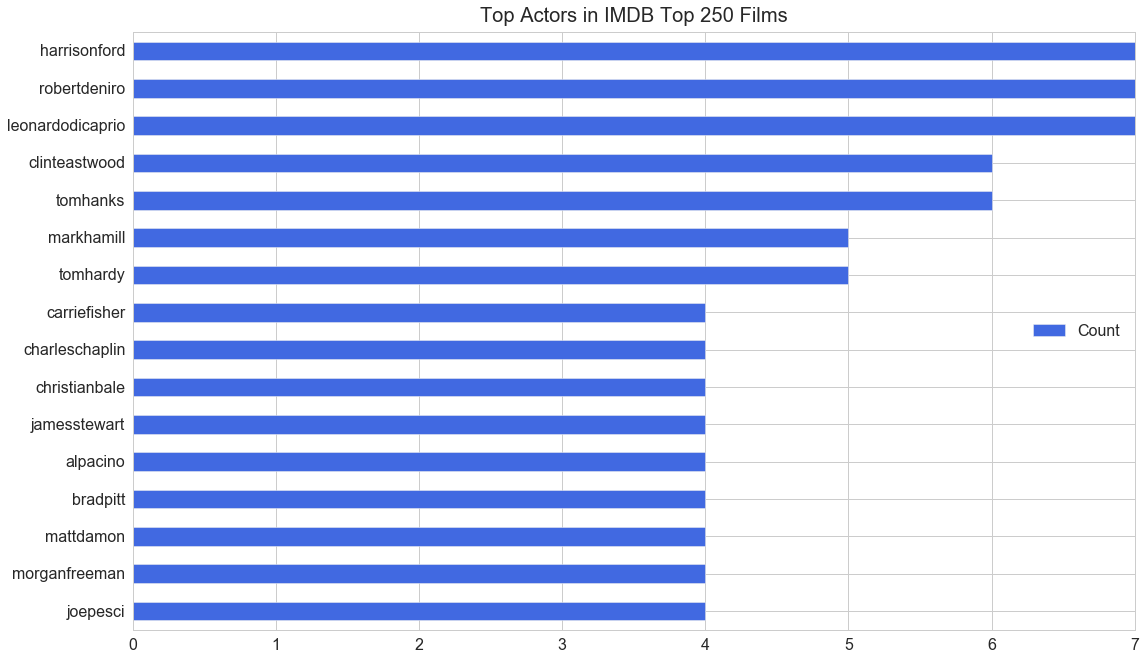

In [356]:
print actors['Count'].value_counts()
top_actors = actors[actors['Count'] > 3]
top_actors.sort_values('Count', ascending=True, inplace=True)
print top_actors.shape
print top_actors.tail()

ax = top_actors.plot(kind='barh', figsize=(16,10), color='royalblue')
ax.set_title('Top Actors in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

                  Count
clinteastwood         6
tomhanks              6
harrisonford          7
robertdeniro          7
leonardodicaprio      7
4    9
3    9
7    3
6    2
5    2
Name: Count, dtype: int64


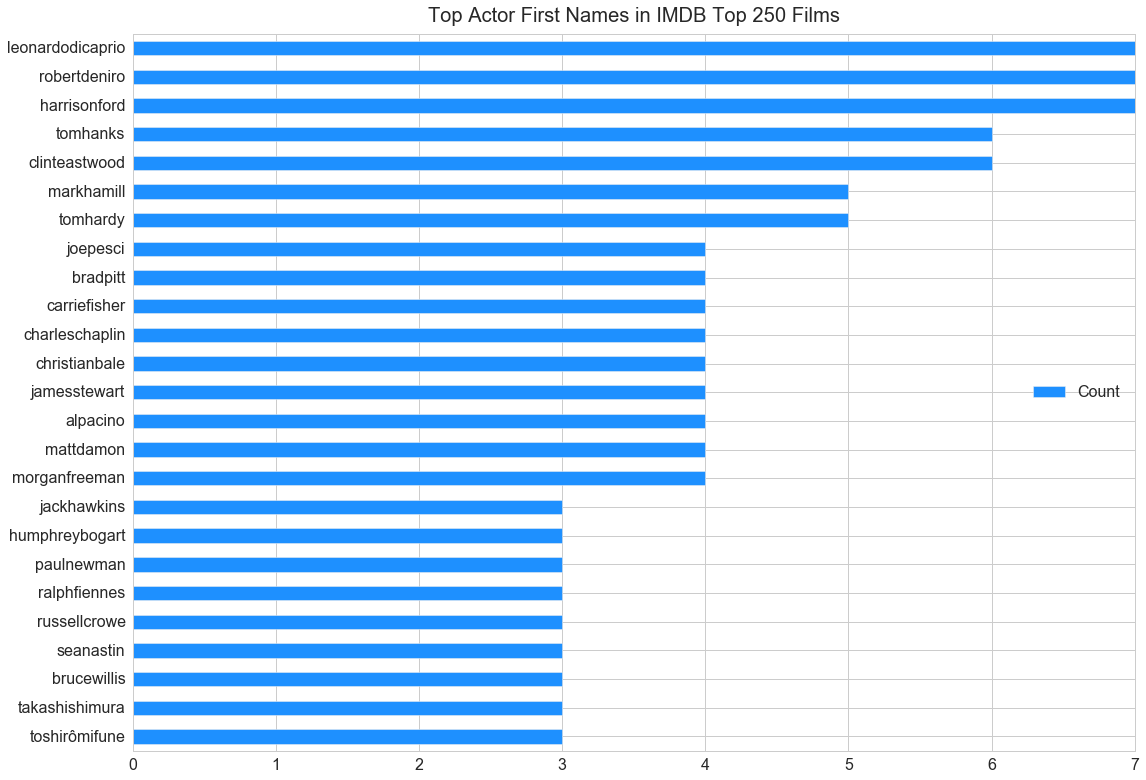

In [357]:
actor_first = cvec.fit_transform(df['Actor_First_Name']).todense()
actor_first_col = cvec.get_feature_names()
actor_first = pd.DataFrame(actor_first, columns=actor_first_col)

actor_first = pd.DataFrame(actor_first.sum())
actor_first.columns = ['Count']
actor_first.sort_values(['Count'], inplace=True)
print actor_first.tail()
print actor_first['Count'].value_counts()

top_actor_first = actor_first[actor_first['Count'] > 2]

"""self, x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, \
sharey=False, layout=None, figsize=None, use_index=True, title=None, \
grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, \
xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, \
colormap=None, table=False, yerr=None, xerr=None, secondary_y=False, \
sort_columns=False, **kwds"""

ax = top_actor_first.plot(kind='barh', figsize=(16,12), color='dodgerblue')
ax.set_title('Top Actor First Names in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Unused Categorical Histograms

In [ ]:
# Ask how to create barh subplots with categorical histograms

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,30), sharex=True)

ax1.barh( color='royalblue')
ax1.set_title('Top Actors in IMDB Top 250 Films', y=1.01)
ax1.tick_params(labelsize=16)
ax1.legend(fontsize=16, loc='center right')

ax2 = top_actor_first.plot(kind='barh', figsize=(16,12), color='dodgerblue')
ax2.set_title('Top Actor First Names in IMDB Top 250 Films', y=1.01)
ax2.tick_params(labelsize=16)
ax2.legend(fontsize=16, loc='center right')

#### Directors 

3    12
7     5
5     4
6     2
4     2
Name: Count, dtype: int64
(13, 1)
                  Count
stevenspielberg       7
christophernolan      7
martinscorsese        7
alfredhitchcock       7
stanleykubrick        7


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


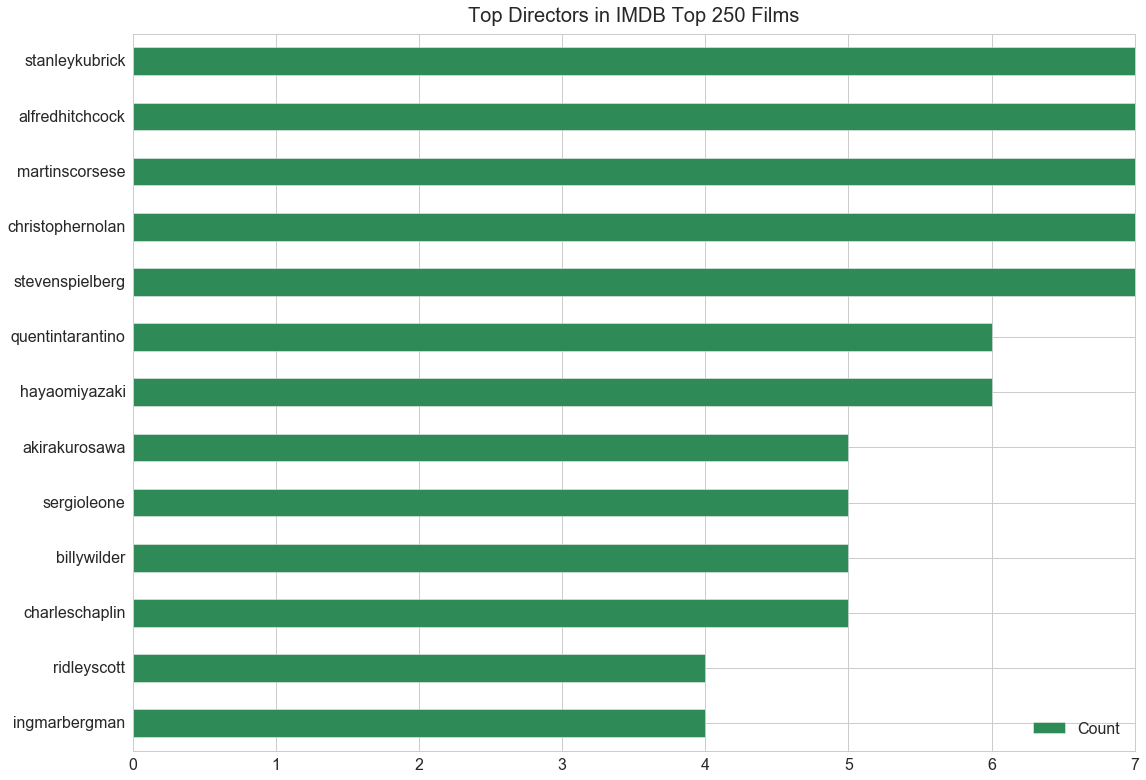

In [358]:
# Create column of concatenated directors to identify unique people
df['Director'] = df['Director'].apply(lambda x: x.replace(' ',''))

directors_df = cvec.fit_transform(df['Director']).todense()
directors_col = cvec.get_feature_names()
directors_df = pd.DataFrame(directors_df, columns=directors_col)
directors = pd.DataFrame(directors_df.sum())
directors.columns = ['Count']
directors.sort_values(['Count'], inplace=True)

print directors['Count'].value_counts()
top_directors = directors[directors['Count'] > 3]
top_directors.sort_values('Count', inplace=True)
print top_directors.shape
print top_directors.tail()

ax = top_directors.plot(kind='barh', figsize=(16,12), color='seagreen')
ax.set_title('Top Directors in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='bottom right')

#### Plot

(25, 1)
        Count
story      22
time       23
father     24
police     26
war        28
new        30
man        34
world      37
young      37
life       48


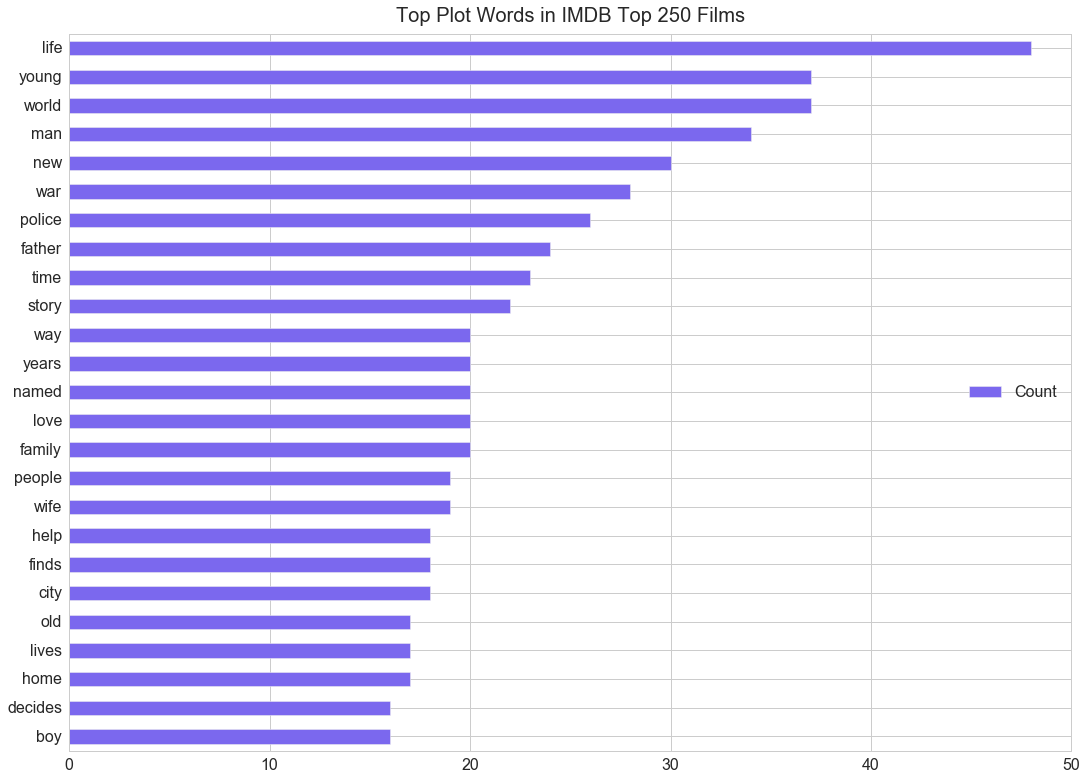

In [359]:
plot_df = cvec.fit_transform(df['Plot']).todense()
plot_col = cvec.get_feature_names()
plot_df = pd.DataFrame(plot_df, columns=plot_col)
plot = pd.DataFrame(plot_df.sum())
plot.columns = ['Count']
plot.sort_values(['Count'], inplace=True)
plot['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_plot = plot[plot['Count'] > 15]
top_plot.sort_values('Count', inplace=True)
print top_plot.shape
print top_plot.tail(10)

ax = top_plot.plot(kind='barh', figsize=(16,12), color='mediumslateblue')
ax.set_title('Top Plot Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Title

(25, 1)
         Count
city         3
day          3
episode      3
man          3
king         3
rings        3
story        3
life         3
wars         4
star         4


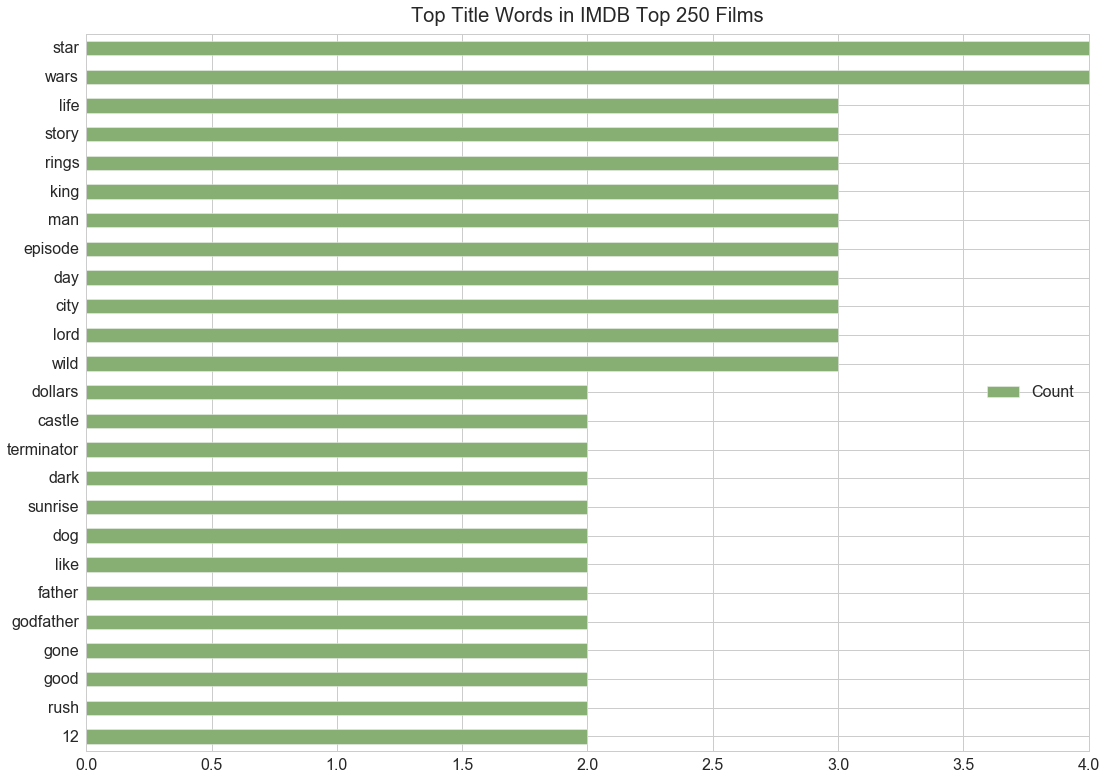

In [360]:
title_df = cvec.fit_transform(df['Title']).todense()
title_col = cvec.get_feature_names()
title_df = pd.DataFrame(title_df, columns=title_col)
title = pd.DataFrame(title_df.sum())
title.columns = ['Count']
title.sort_values(['Count'], inplace=True)
title['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_title = title[title['Count'] > 1]
top_title.sort_values('Count', inplace=True)
print top_title.shape
print top_title.tail(10)

ax = top_title.plot(kind='barh', figsize=(16,12), color='sage')
ax.set_title('Top Title Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Genre

(23, 1)
           Count
sci           22
fantasy       23
biography     26
mystery       31
action        35
thriller      40
comedy        42
crime         55
adventure     61
drama        173


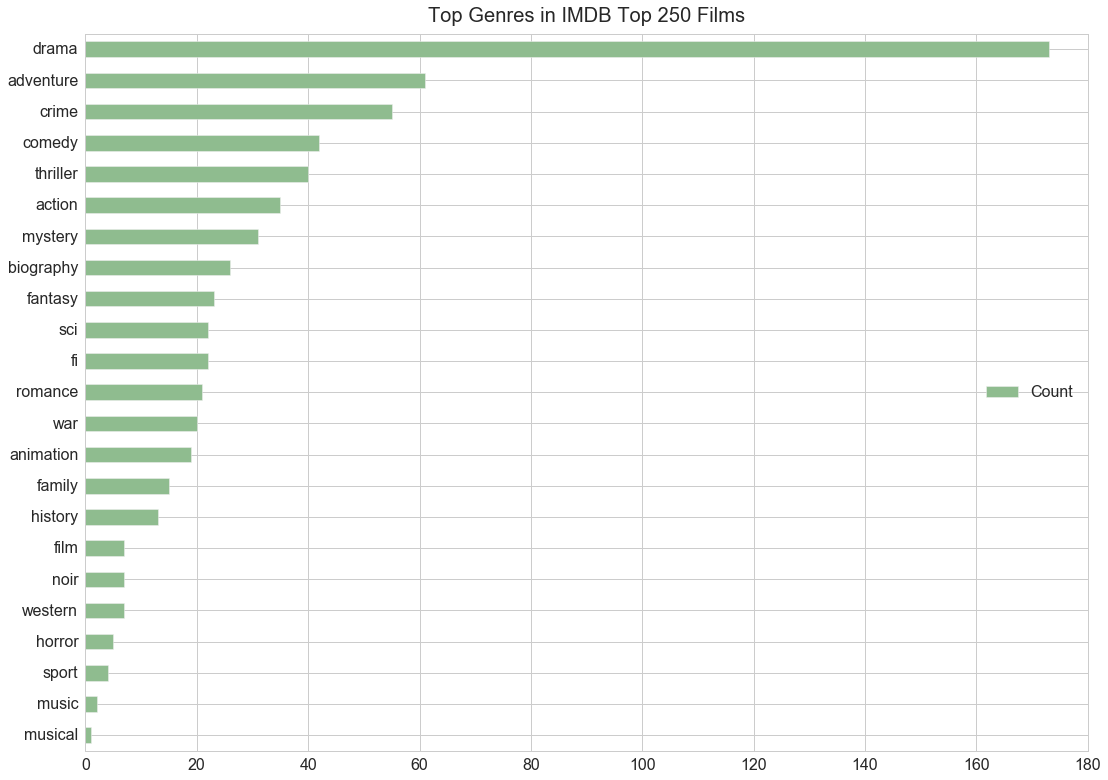

In [361]:
genre_df = cvec.fit_transform(df['Genre']).todense()
genre_col = cvec.get_feature_names()
genre_df = pd.DataFrame(genre_df, columns=genre_col)
genre = pd.DataFrame(genre_df.sum())
genre.columns = ['Count']
genre.sort_values(['Count'], inplace=True)
genre['Count'].value_counts().sort_values(ascending=True)

# print plot['Count'].value_counts()
top_genre = genre[genre['Count'] > 0]
top_genre.sort_values('Count', inplace=True)
print top_genre.shape
print top_genre.tail(10)

ax = top_genre.plot(kind='barh', figsize=(16,12), color='darkseagreen')
ax.set_title('Top Genres in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

#### Production Company

0    SonyPicturesClassics
1        ColumbiaPictures
2       ParamountPictures
Name: Production, dtype: object
(19, 1)
                    Count
mgm                     6
waltdisneypictures      7
columbiapictures       10
miramaxfilms           10
20thcenturyfox         11
universalpictures      12
unitedartists          13
paramountpictures      18
pictures               21
warnerbros             30


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


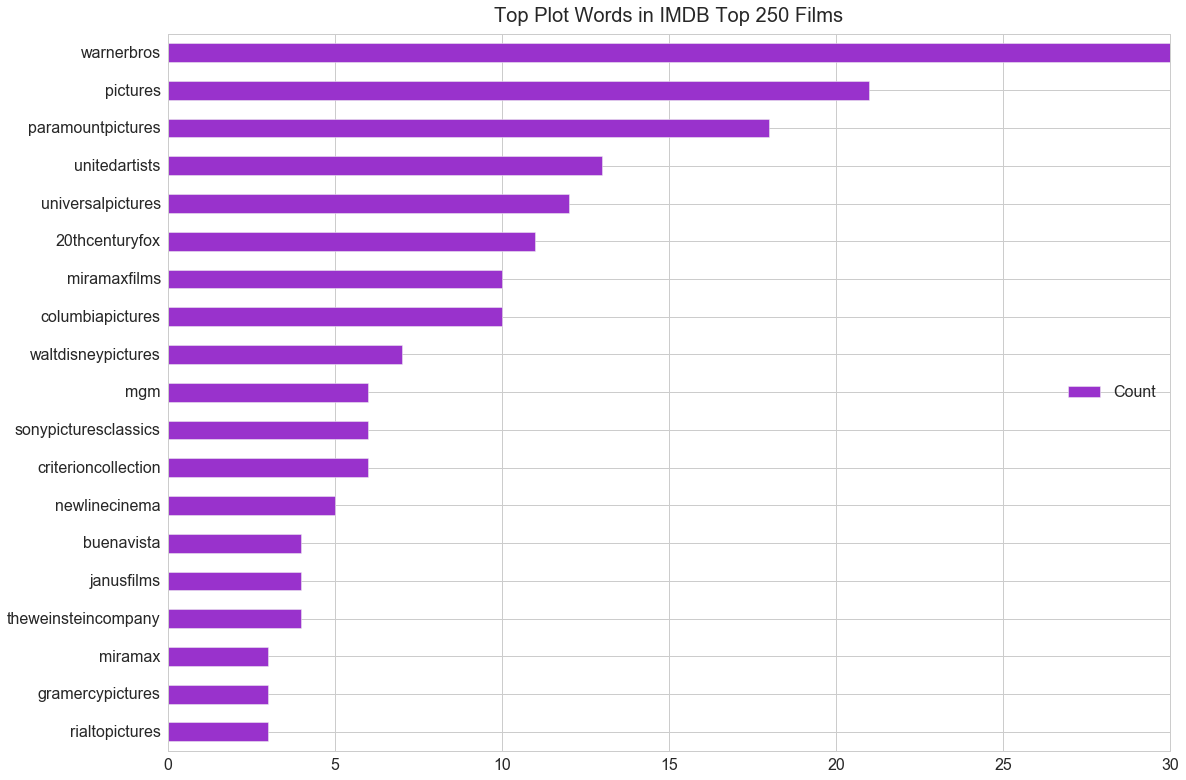

In [362]:
# Create column of concatenated production company names to identify unique companies
df['Production'] = df['Production'].apply(lambda x: x.replace(' ',''))
print df['Production'].head(3)

production_df = cvec.fit_transform(df['Production']).todense()
production_col = cvec.get_feature_names()
production_df = pd.DataFrame(production_df, columns=production_col)
production = pd.DataFrame(production_df.sum())
production.columns = ['Count']
production.sort_values(['Count'], inplace=True)
production['Count'].value_counts().sort_values(ascending=True)

# print production['Count'].value_counts()
top_production = production[production['Count'] > 2]
top_production.sort_values('Count', inplace=True)
print top_production.shape
print top_production.tail(10)

ax = top_production.plot(kind='barh', figsize=(16,12), color='darkorchid')
ax.set_title('Top Plot Words in IMDB Top 250 Films', y=1.01)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='center right')

### New dataframes for limited top categorical columns

In [363]:
print top_actors.shape
print top_directors.shape
print top_plot.shape
print top_title.shape
print top_genre.shape
print top_production.shape

(16, 1)
(13, 1)
(25, 1)
(25, 1)
(23, 1)
(19, 1)


In [364]:
top_actors1 = top_actors
top_directors1 = top_directors

top_plot1 = plot[plot['Count'] > 20]
top_plot1.sort_values('Count', inplace=True)
print top_plot1.shape

top_title1 = title[title['Count'] > 2]
top_title1.sort_values('Count', inplace=True)
print top_title1.shape

top_genre1 = genre[genre['Count'] > 15]
top_genre1.sort_values('Count', inplace=True)
print top_genre1.shape

top_production1 = production[production['Count'] > 8]
top_production1.sort_values('Count', inplace=True)
print top_production1.shape

(10, 1)
(12, 1)
(14, 1)
(8, 1)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

## EDA

### Histograms

#### Year, Runtime, Gross

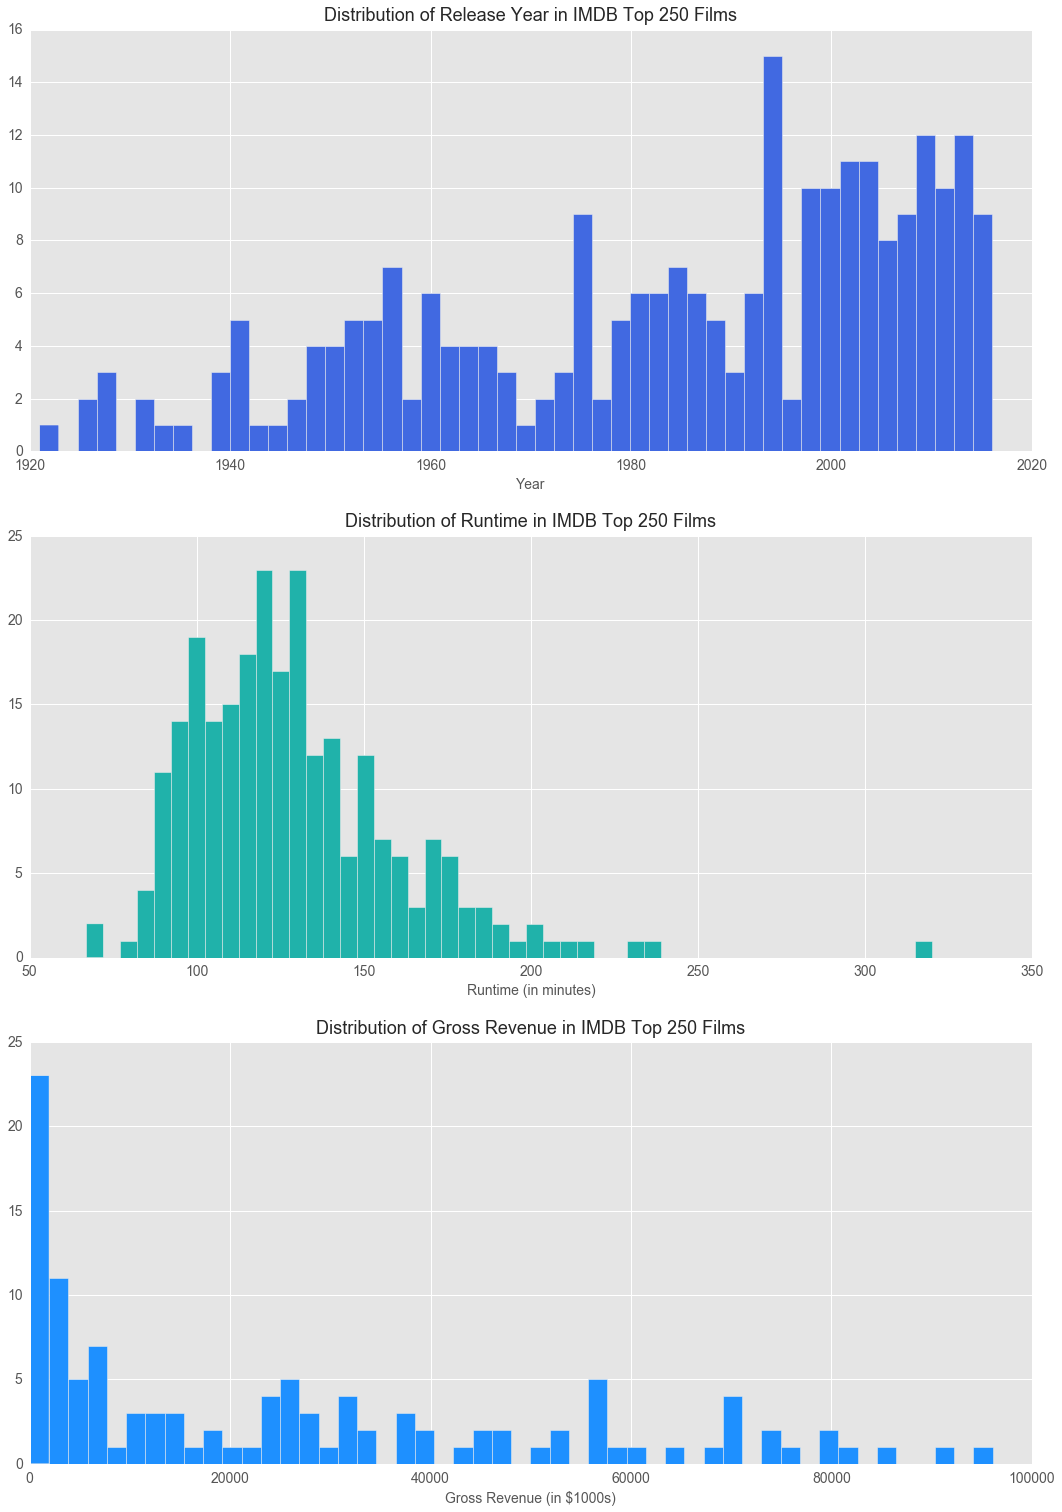

In [123]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,24))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.hist(df['Year'], bins=50, color='royalblue')
ax1.set_title('Distribution of Release Year in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylim(top=16)
ax1.tick_params(labelsize=14)

ax2.hist(df['Runtime'], bins=50, color='lightseagreen')
ax2.set_title('Distribution of Runtime in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax2.set_xlabel('Runtime (in minutes)', fontsize=14)
ax2.tick_params(labelsize=14)

gross_hist = df[df['Gross'] < 100000000]
gross_hist = gross_hist[gross_hist['Gross'] > 0]
ax3.hist(gross_hist['Gross']/1000, bins=50, color='dodgerblue')
ax3.set_title('Distribution of Gross Revenue in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax3.set_xlabel('Gross Revenue (in $1000s)', fontsize=14, y = -2.01)
ax3.tick_params(labelsize=14)

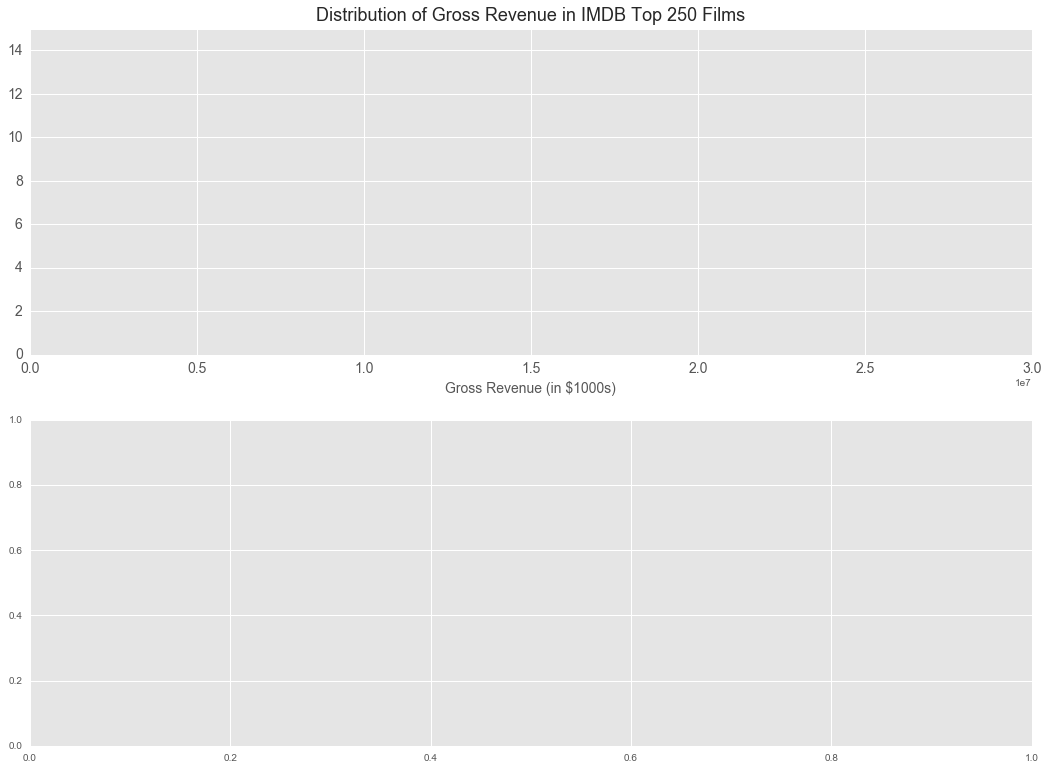

In [161]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


gross_hist = df[df['Gross'] < 10000000]
gross_hist = gross_hist[gross_hist['Gross'] > 0]
ax1.hist(gross_hist['Gross']/1000, bins=25, color='dodgerblue')
ax1.set_title('Distribution of Gross Revenue in IMDB Top 250 Films', \
             fontsize=18, y=1.01)
ax1.set_xlabel('Gross Revenue (in $1000s)', fontsize=14, y = -2.01)
ax1.set_ylim(top=15)
ax1.tick_params(labelsize=14)
ax1.axvline(x=((gross_median*corr_index)),ymin=0,ymax=None,\
            c="red",linewidth=5,zorder=0)


#### Reviews

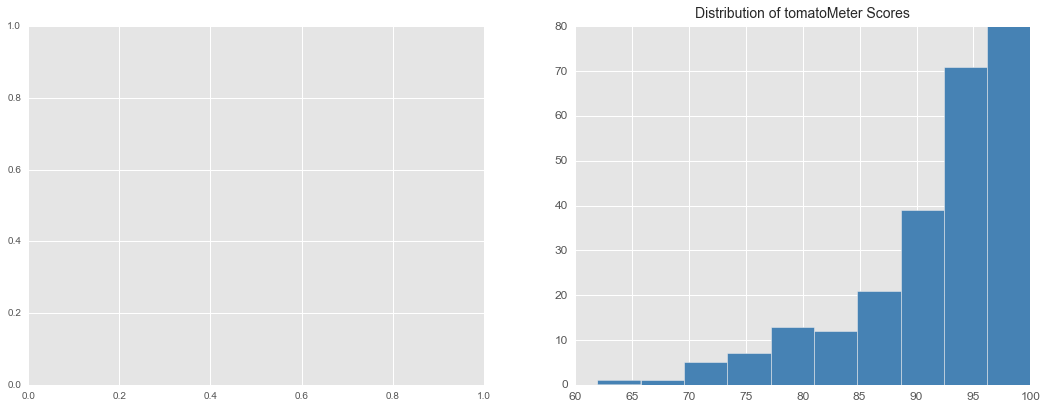

In [125]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,6))

# metascore = df[df['Metascore'] > 0]
# ax1.hist(metascore['Metascore'], color='royalblue')
# ax1.set_title('Distribution of Metascores', \
#              fontsize=14, y=1.01)
# ax1.tick_params(labelsize=12)

tomatoMeter = df[df['tomatoMeter'] > 0]
ax2.hist(tomatoMeter['tomatoMeter'], color='steelblue')
ax2.set_title('Distribution of tomatoMeter Scores', \
             fontsize=14, y=1.01)
ax2.tick_params(labelsize=12)

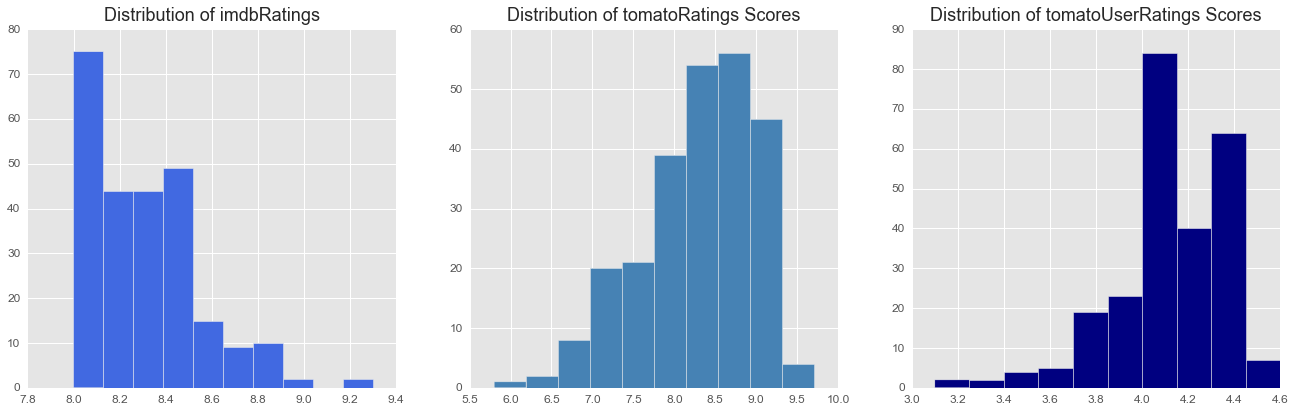

In [127]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

imdbRating = df[df['imdbRating'] > 0]
ax1.hist(df['imdbRating'], color='royalblue')
ax1.set_title('Distribution of imdbRatings', \
             fontsize=18, y=1.01)
ax1.tick_params(labelsize=12)

tomatoRating = df[df['tomatoRating'] > 0]
ax2.hist(tomatoMeter['tomatoRating'], color='steelblue')
ax2.set_title('Distribution of tomatoRatings Scores', \
             fontsize=18, y=1.01)
ax2.tick_params(labelsize=12)

tomatoRating = df[df['tomatoRating'] > 0]
ax2.hist(tomatoMeter['tomatoRating'], color='steelblue')
ax2.set_title('Distribution of tomatoRatings Scores', \
             fontsize=18, y=1.01)


tomatoUserRating = df[df['tomatoUserRating'] > 0]
ax3.hist(tomatoMeter['tomatoUserRating'], color='navy')
ax3.set_title('Distribution of tomatoUserRatings Scores', \
             fontsize=18, y=1.01)
ax3.tick_params(labelsize=12)

### Scatterplots

In [ ]:
pairplot_cols = ['Gross', 'imdbRating', 'imdbVotes', \
                 'tomatoMeter', 'tomatoRating', 'tomatoReviews', 'tomatoFresh', \
                 'tomatoRotten', 'Oscars_Won', 'Oscar_Noms', 'Awards_Won', 'Other_Noms']
pairplot_df = df.loc[:, pairplot_cols]
sns.pairplot(pairplot_df)

### Unused Separate Histograms

In [ ]:
bins_dict = {'Year': 50, 'Runtime': 50, 'imdbRating': 50}
facecolor_dict = {'Year': 'royalblue', 'Runtime': 'coral', 'imdbRating': 'lightseagreen'}
axis_titles = {'Year': 'Distribution of Years in IMDB Top 250 Films',
              'Runtime': 'Distribution of Runtime in IMDB Top 250 Films',
              'imdbRating': 'Distribution of Years in IMDB Top 250 Films'}
#data, column=None, by=None, grid=True, xlabelsize=None, 
#xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=False, 
#sharey=False, figsize=None, layout=None, bins=10, **kwds)¶
xlabel = 14
ylabel = 14
year_bins = 50
df['Year'].hist(figsize=(16,4),xlabelsize=xlabel, ylabelsize=ylabel, bins=bins_dict['Year'],
               facecolor=facecolor_dict['Year'], alpha = .85)

In [ ]:
bins_dict = {'Year': 50, 'Runtime': 50, 'imdbRating': 50}
facecolor_dict = {'Year': 'royalblue', 'Runtime': 'coral', 'imdbRating': 'lightseagreen'}
axis_titles = {'Year': 'Distribution of Years in IMDB Top 250 Films',
              'Runtime': 'Distribution of Runtime in IMDB Top 250 Films',
              'imdbRating': 'Distribution of Years in IMDB Top 250 Films'}


def hist_plot(x):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(111)
    n, bins, patches = ax.hist(x,  bins=bins_dict[x], facecolor=facecolor_dict[x], alpha=0.85)
    ax.set_title(axis_titles[x], fontsize=20, y=1.02)
    #ax.set_xticklabels(labels, fontsize=16)
    #ax.set_xticks(labels)
    #ax.set_ylim(0, 16)
    #y_labels = [i for i in range(18) if i%2 == 0]
    #ax.set_yticklabels(y_labels, fontsize=16)

In [ ]:
# Years
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df['Year'],  bins=50, facecolor='royalblue', alpha=0.85)

def decades():
    i = 1910
    labels = []
    while i < 2020:
        labels.append(i + 10)
        i += 10
    return labels
labels = decades()

ax.set_title('Distribution of Years in IMDB Top 250 Films', fontsize=20, y=1.02)
ax.set_xticklabels(labels, fontsize=16)
ax.set_xticks(labels)
ax.set_ylim(0, 16)
y_labels = [i for i in range(18) if i%2 == 0]
ax.set_yticklabels(y_labels, fontsize=16)

In [ ]:
# Runtime
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(df['Runtime'],  bins=50, facecolor='coral', alpha=0.85)

ax.set_title('Distribution of Runtime in IMDB Top 250 Films', fontsize=20, y=1.02)

### Other

## Standardizing and Dummies

### Use StandardScaler to standardize numerical data

In [365]:
# Isolate numeric columns for standardizing
number_cols = [i for i in df.columns if df[i].dtype == 'float64' \
              or df[i].dtype == 'int']
number_cols.remove('Gross')
number_cols

['Year',
 'imdbRating',
 'imdbVotes',
 'tomatoMeter',
 'tomatoRating',
 'tomatoReviews',
 'tomatoUserMeter',
 'tomatoUserRating',
 'tomatoUserReviews',
 'tomatoFresh',
 'tomatoRotten',
 'Runtime',
 'Oscars_Won',
 'Awards_Won',
 'Other_Noms',
 'Oscar_Noms',
 'Adj_Gross']

In [366]:
# Standardize numeric columns
standardscaler = StandardScaler()
df.loc[:, number_cols] = standardscaler.fit_transform(df[number_cols])

In [367]:
# Create dummy variables for categorical columns
print top_actors1.shape
print top_directors1.shape
print top_plot1.shape
print top_title1.shape
print top_genre1.shape
print top_production1.shape

# actors, directors, plot, title, genre, production, rated, genre1

(16, 1)
(13, 1)
(10, 1)
(12, 1)
(14, 1)
(8, 1)


### Create dummy variables

In [368]:
# Create dummy variables for rated column
rated = pd.get_dummies(df['Rated'], prefix='Rated')
rated.head(3)

,Rated_G,Rated_OTHER,Rated_PG,Rated_PG-13,Rated_R
0,0,0,0,0,1
1,0,1,0,0,0
2,0,0,1,0,0


In [369]:
# Create dummy variables for genre column
genre = pd.get_dummies(df['Genre_1'], prefix='Genre')
genre.head(3)

,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,Genre_Drama,Genre_Film-Noir,Genre_Horror,Genre_Mystery,Genre_Sci-Fi,Genre_Western
0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0


In [370]:
# Create dummy variables for genre column
season = pd.get_dummies(df['Season'], prefix='Season')
season.head(3)

,Season_Fall,Season_Holiday,Season_Summer,Season_Winter
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0


In [579]:
# Create dummy variables for month column
month = pd.get_dummies(df['Month'], prefix='Month')
month.head(3)

,Month_,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0


### Create a new model_df by concatenating other dataframes together

In [ ]:
# list of dataframes:
"""
df
actors_df
directors_df
plot_df
title_df
genre_df
production_df
rated
genre
season
month
"""

In [580]:
model_df = df[['Year', 'Released', 'imdbRating', 'imdbVotes', \
             'tomatoMeter', 'tomatoRating', 'tomatoReviews', \
             'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', \
             'tomatoFresh', 'tomatoRotten', 'Runtime', \
              'Oscars_Won', 'Awards_Won', 'Oscar_Noms', 'Other_Noms', \
             'Adj_Gross']]
model_df.head(2)

,Year,Released,imdbRating,imdbVotes,tomatoMeter,tomatoRating,tomatoReviews,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoFresh,tomatoRotten,Runtime,Oscars_Won,Awards_Won,Oscar_Noms,Other_Noms,Adj_Gross
0,1.229622,2014-10-15,0.785598,0.016558,0.267304,0.430101,1.707688,0.432796,1.663009,-0.240090,1.853135,0.302536,-0.689298,0.719495,1.646788,-0.483864,1.991285,-0.669178
1,-1.242477,1956-11-19,1.645114,-0.519615,1.087254,1.431001,-0.642785,1.168845,1.663009,-0.236487,-0.582894,-0.727900,2.440462,-0.657090,-0.588474,0.750482,-0.623542,-0.778913


In [581]:
print 'df', df.shape
print 'actors_df', actors_df.shape
print 'directors_df', directors_df.shape
print 'plot_df', plot_df.shape
print 'title_df', title_df.shape
print 'genre_df', genre_df.shape
print 'production_df', production_df.shape
print 'rated', rated.shape
print 'genre', genre.shape
print 'season', season.shape
print 'month', month.shape

df (250, 36)
actors_df (250, 25)
directors_df (250, 25)
plot_df (250, 25)
title_df (250, 25)
genre_df (250, 23)
production_df (250, 25)
rated (250, 5)
genre (250, 12)
season (250, 4)
month (250, 13)


In [ ]:
# model_df = pd.concat([model_df, actors_df, directors_df, plot_df, title_df, \
#                      genre_df, production_df, rated, genre, season], axis=1)
# print model_df.shape
# model_df.head(2)

In [625]:
model_df1 = pd.concat([model_df, actors_df, directors_df, plot_df, title_df,
                      genre_df, production_df, rated, genre, season, month], 
                      axis=1)
print model_df1.shape
model_df1.head(2)

(250, 200)


,Year,Released,imdbRating,imdbVotes,tomatoMeter,tomatoRating,tomatoReviews,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,...,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,1.229622,2014-10-15,0.785598,0.016558,0.267304,0.430101,1.707688,0.432796,1.663009,-0.240090,...,0,0,0,0,0,0,0,0,1,0
1,-1.242477,1956-11-19,1.645114,-0.519615,1.087254,1.431001,-0.642785,1.168845,1.663009,-0.236487,...,0,0,0,0,0,0,0,1,0,0


## Modeling

In [626]:
X = model_df1.drop(['imdbRating', 'Released'], axis=1)
y = model_df1['imdbRating']

### Regressions

In [658]:
### Regressors ###
# dt = DecisionTreeRegressor()
# bdt = BaggingRegressor(DecisionTreeRegressor())
# rf = RandomForestRegressor()
# ada = AdaBoostRegressor()
# gd = GradientDescentRegressor()
#models_list = [dt, bdt, rf, ada, gd]
model_list = [
    ['DecisionTree_Reg', DecisionTreeRegressor(random_state=7)],
    ['Bagging_Reg', BaggingRegressor(random_state=7)],
    ['RandomForest_Reg', RandomForestRegressor(n_jobs=-1, random_state=7)],
    ['ExtraTrees_Reg', ExtraTreesRegressor(n_jobs=-1, random_state=7)],
    ['AdaBoost_Reg', AdaBoostRegressor(random_state=7)],
    ['GradientBoost_Reg', GradientBoostingRegressor(criterion='mse', 
                                                          random_state=7)]]

In [640]:
cv = KFold(5, random_state=7, shuffle=True)
cv

KFold(n_splits=5, random_state=7, shuffle=True)

In [659]:
model_metrics = []

In [660]:
# Return cross_val_score from model
def run_model(regressor):
    score = cross_val_score(regressor, X, y,
                            scoring='neg_mean_squared_error', cv=cv)
    return score

####### Error #######
# Error when trying to set n_job=-1
# //anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: 
# UserWarning: Multiprocessing-backed parallel loops cannot be nested, 
# setting n_jobs=1 **self._backend_args) 

In [679]:
# Run model and return mean and std of mse and append to model_list
def get_metrics(model_list):
    for i in model_list:
        result = run_model(i[1])
        mean = result.mean()*-1.0
        std = result.std()
        model_2.append([i[0], mean, std])
    return model_2

In [680]:
get_metrics(model_list)

[['DecisionTree_Reg', 0.54890499732565867, 0.070186895881003047],
 ['Bagging_Reg', 0.3416508816463309, 0.093575631694918282],
 ['RandomForest_Reg', 0.32709714214792535, 0.11792093011821979],
 ['ExtraTrees_Reg', 0.3839970922071746, 0.094098535422980967],
 ['AdaBoost_Reg', 0.33631590790973676, 0.098506352802442132],
 ['GradientBoost_Reg', 0.28402476428058493, 0.085374055018251363]]

### Bagging + Regressors

In [682]:
bagging_model_list = [
    ['DecisionTree_Reg_BAGGING', DecisionTreeRegressor(random_state=7)],
    ['RandomForest_Reg_BAGGING', RandomForestRegressor(n_jobs=-1, random_state=7)],
    ['ExtraTrees_Reg_BAGGING', ExtraTreesRegressor(n_jobs=-1, random_state=7)],
    ['AdaBoost_Reg_BAGGING', AdaBoostRegressor(random_state=7)],
    ['GradientBoost_Reg_BAGGING', GradientBoostingRegressor(criterion='mse', 
                                                          random_state=7)]]

In [686]:
bagging_metrics = []

In [687]:
def get_bagging_metrics(model_list):
    for i in model_list:
        result = run_model(BaggingRegressor(i[1], random_state=7))
        mean = result.mean()*-1.0
        std = result.std()
        bagging_metrics.append([i[0], mean, std])
    return bagging_metrics

get_bagging_metrics(bagging_model_list)

[['DecisionTree_Reg_BAGGING', 0.3314780393674962, 0.095940948579522595],
 ['RandomForest_Reg_BAGGING', 0.32642855665320158, 0.1145147187308688],
 ['ExtraTrees_Reg_BAGGING', 0.37598211884716681, 0.13678278748793674],
 ['AdaBoost_Reg_BAGGING', 0.34492710442417984, 0.12186522657054653],
 ['GradientBoost_Reg_BAGGING', 0.29125800810415298, 0.10642077923654408]]

### GridSearch Regressors

In [ ]:
GS_model_list = [
    ['DecisionTree_GS', DecisionTreeRegressor(random_state=7)],
    ['RandomForest_GS', RandomForestRegressor(n_jobs=-1, random_state=7)],
    ['GradientBosst_GS', GradientBoostingRegressor(criterion='mse', 
                                                          random_state=7)]]

In [649]:
parameters = {'max_features':[3,4,5,6], 'max_leaf_nodes':[9,10,11,12], 
              'min_samples_split':[2,3,4], 'max_depth':[5,6,7,8,9], 
              'min_samples_leaf':[1,2,3,4]}

scoring = 'neg_mean_squared_error'

In [ ]:
def get_bagging_metrics(model_list):
    for i in model_list:
        result = run_model(BaggingRegressor(i[1], random_state=7))
        mean = result.mean()*-1.0
        std = result.std()
        bagging_metrics.append([i[0], mean, std])
    return bagging_metrics

In [ ]:
GS_metrics = []

In [694]:
def run_model(regressor):
    score = cross_val_score(regressor, X, y,
                            scoring='neg_mean_squared_error', cv=cv)
    return score

def run_GS(regressor):
    GS = GridSearchCV(regressor, param_grid=parameters, scoring=scoring, cv=5, 
                     verbose=True, n_jobs=-1)
    GS.fit(X,y)
    print 'GS best params: ', GSdt.best_params_
    result = run_model(GS.best_estimator_)
    mean = result.mean()*1.0
    std = result.std()
    GS_metrics.append
    
    
# result = run_model(GSdt.best_estimator_)
# result.mean()

In [695]:
run_GS(model)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 3240 tasks      | elapsed:    9.0s


GS best params:  {'max_features': 4, 'max_leaf_nodes': 11, 'min_samples_split': 3, 'max_depth': 7, 'min_samples_leaf': 1}


[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   12.8s finished


-0.81761958460781803

In [650]:
model = DecisionTreeRegressor(random_state=7)
GSdt = GridSearchCV(model, param_grid=parameters, scoring=scoring, cv=5,
                   verbose=True, n_jobs=-1)
GSdt.fit(X,y)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 3928 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   12.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=7,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [3, 4, 5, 6], 'max_leaf_nodes': [9, 10, 11, 12], 'min_samples_split': [2, 3, 4], 'max_depth': [5, 6, 7, 8, 9], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=True)

In [651]:
print 'GSdt best params: ', GSdt.best_params_

GSdt best params:  {'max_features': 4, 'max_leaf_nodes': 11, 'min_samples_split': 3, 'max_depth': 7, 'min_samples_leaf': 1}


In [653]:
result = run_model(GSdt.best_estimator_)
result.mean()

-0.81761958460781803

In [310]:
# functions to print out results of model fits
def grid_search_results(model, x, y, cv):
    
    m = np.mean(cross_val_score(model,x,y,cv=cv))
    s = np.std(cross_val_score(model,x,y,cv=cv))
    print"Mean R2 score from cross validation:\t{:0.3} ± {:0.3}".format(round(m,3), round(s,3))
    
def train_test_results(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    r = r2_score(y_test,y_pred)
    print("R2 score from train/test:\t\t{:0.3}".format(round(r,3)))

In [312]:
grid_search_results(reg.best_estimator_, X, y, cv)
train_test_results(reg.best_estimator_)

Mean R2 score from cross validation:	-0.012 ± 0.018
R2 score from train/test:		-0.034


In [304]:
# functions to print results
def grid_search_class(model, x, y, cv):
    
    m = np.mean(cross_val_score(model,x,y,cv=cv))
    s = np.std(cross_val_score(model,x,y,cv=cv))
    print"Mean Accuracy score from cross validation:\t{:0.3} ± {:0.3}".format(round(m,3), round(s,3))
    
def train_test_class(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print classification_report(y_test,y_pred)

### Bagged Decision Trees

In [314]:
# bagged decision trees
bag = BaggingRegressor(DecisionTreeRegressor())

params = {"base_estimator__max_depth": [1,3,5,10],
          "base_estimator__max_features": [1,2,3,4],
          "base_estimator__min_samples_leaf": [1,3, 5, 7, 10],
          "base_estimator__min_samples_split": [2, 7],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10],
         }

grid_bag = GridSearchCV(BaggingRegressor(DecisionTreeRegressor()), params, n_jobs=-1, verbose=True)
grid_bag.fit(X,y)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
//anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 586 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 2986 tasks      | ela

GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_samples': [0.5, 0.7, 1.0], 'base_estimator__min_samples_split': [2, 7], 'base_estimator__max_depth': [1, 3, 5, 10], 'base_estimator__max_features': [1, 2, 3, 4], 'n_estimators': [2, 5, 10], 'max_features': [0.5, 0.7, 1.0], 'base_estimator__min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [316]:
grid_search_results(grid_bag.best_estimator_,X,y,cv)
train_test_results(grid_bag.best_estimator_)

Mean R2 score from cross validation:	0.216 ± 0.083
R2 score from train/test:		0.251


### Random Forest GridSearch

In [317]:
# random forest
rf = RandomForestRegressor()
params = {"max_depth": [1,3,5,10],
          "max_features": [1,2,3,4],
          "min_samples_leaf": [1,3, 5, 7, 10],
          "min_samples_split": [2, 7]}

grid_rf = GridSearchCV(rf, params, n_jobs=-1, verbose=True)
grid_rf.fit(X,y)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   17.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4], 'min_samples_split': [2, 7], 'max_depth': [1, 3, 5, 10], 'min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [319]:
grid_search_results(grid_rf.best_estimator_,X,y,cv)
train_test_results(grid_rf.best_estimator_)

Mean R2 score from cross validation:	0.137 ± 0.071
R2 score from train/test:		0.169


### Adaboost

In [321]:
ada = AdaBoostRegressor()
ada.fit(X,y)

grid_search_results(ada,X,y,cv)
train_test_results(ada)

Mean R2 score from cross validation:	0.652 ± 0.031
R2 score from train/test:		0.522


In [322]:
grad = GradientBoostingRegressor()
grad.fit(X,y)

grid_search_results(grad,X,y,cv)
train_test_results(grad)

Mean R2 score from cross validation:	0.674 ± 0.025
R2 score from train/test:		0.575


In [344]:
cross_val_score(ada, X, y=y, scoring='neg_mean_squared_error', cv=5).mean()

-0.33112077969084869

In [345]:
cross_val_score(grad, X, y=y, scoring='neg_mean_squared_error', cv=5).mean()

-0.29603871857518493

In [346]:
cross_val_score(grid_rf, X, y=y, scoring='neg_mean_squared_error', cv=5).mean()

Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   13.1s finished


Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   14.1s finished


Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   15.6s finished


Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   17.5s finished


Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   11.4s finished


-0.82017707100786907

In [338]:
models.remove(reg)